This notebook examines the dynamic windage from using SalishSea BC12o, HRDPS, and 2016 SCT drifter data.

In [1]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from shapely.geometry.polygon import Polygon
from shapely.geometry import Point

In [2]:
with open ('/home/soontiensn/data/gpsc-work2/OPP/dynamic-windage-test/drifter_salish.txt') as f:
    drifters= f.read()

# SalishSea

In [3]:
def load_data(data_dir, region, drifters):
    alpha_real = []
    alpha_imag = []
    u_drifter = []
    v_drifter = []
    u_ocean = []
    v_ocean = []
    u_atmos = []
    v_atmos = []
    lon = []
    lat = []
    files = glob.glob(os.path.join(data_dir, '*/output', '*.nc'))
    for f in files:
        basename=os.path.basename(f)
        buoyid = basename.split('_')[-1].split('.nc')[0]
        if buoyid in drifters:
            d = xr.open_dataset(f)
            alpha_real.extend(d.alpha_real.values)
            alpha_imag.extend(d.alpha_imag.values)
            u_drifter.extend(d.ueast_drifter.values)
            v_drifter.extend(d.vnorth_drifter.values)
            u_ocean.extend(d.ueast_ocean.values)
            u_atmos.extend(d.ueast_atmos.values)
            v_ocean.extend(d.vnorth_ocean.values)
            v_atmos.extend(d.vnorth_atmos.values)
            lon.extend(d.lon.values)
            lat.extend(d.lat.values)
    else:
        print('drifter {} not used in simulations'.format(buoyid))
    
    alpha_real_mask = np.ma.masked_invalid(alpha_real)
    alpha_imag_mask = np.ma.masked_invalid(alpha_imag)
    u_drifter_mask = np.ma.masked_invalid(u_drifter)
    v_drifter_mask = np.ma.masked_invalid(v_drifter)
    u_ocean_mask = np.ma.masked_invalid(u_ocean)
    v_ocean_mask = np.ma.masked_invalid(v_ocean)
    u_atmos_mask = np.ma.masked_invalid(u_atmos)
    v_atmos_mask = np.ma.masked_invalid(v_atmos)
    lons = np.array(lon)
    lats = np.array(lat)
    # Check if position in region
    count=0
    for lon, lat in zip(lons, lats):
        point = Point(lon, lat)
        if not region.contains(point):
            lons[count] = np.nan
            lats[count] = np.nan
        count+=1
    lons = np.ma.masked_invalid(lons)
    lats = np.ma.masked_invalid(lats)
    d = xr.Dataset(
        #coords={'i', np.arange(lons.size)},
        data_vars={'lon': ('i', lons),
                   'lat': ('i', lats),
                   'ueast_drifter': ('i', u_drifter_mask),
                   'vnorth_drifter': ('i', v_drifter_mask),
                   'ueast_ocean': ('i', u_ocean_mask),
                   'vnorth_ocean': ('i', v_ocean_mask),
                   'ueast_atmos': ('i', u_atmos_mask),
                   'vnorth_atmos': ('i', v_atmos_mask),
                   'alpha_real': ('i', alpha_real_mask),
                   'alpha_imag': ('i', alpha_imag_mask),})
    d = d.dropna('i', how='any')
    return d

In [4]:
mesh = xr.open_dataset('/home/soontiensn/data/gpsc-work2/models/SalishSea-BC12/mesh_mask201702MD.nc')
polygon_coords = [[mesh.nav_lon.values[0,0], mesh.nav_lat.values[0,0]],
                  [mesh.nav_lon.values[0,-1], mesh.nav_lat.values[0,-1]],
                  [mesh.nav_lon.values[-1,-1], mesh.nav_lat.values[-1,-1]],
                  [mesh.nav_lon.values[-1,0], mesh.nav_lat.values[-1,0]]]
print(polygon_coords)

[[-123.429436, 46.859665], [-121.31835, 47.60092], [-124.34199, 51.1048], [-126.40029, 50.389927]]


In [5]:
region = Polygon(polygon_coords) 

In [6]:
data_dir='/home/soontiensn/data/gpsc-work2/OPP/dynamic-windage-test/SalishSea-IOS/'
dcombine = load_data(data_dir, region, drifters)

drifter wp3132544483D20160418 not used in simulations


In [7]:
dcombine

<xarray.Dataset>
Dimensions:         (i: 5848)
Dimensions without coordinates: i
Data variables:
    lon             (i) float64 -124.6 -124.6 -124.6 ... -123.4 -123.4 -123.4
    lat             (i) float64 48.42 48.43 48.43 48.44 ... 49.47 49.47 49.47
    ueast_drifter   (i) float64 -0.1235 0.02816 -0.03013 ... 0.006152 0.006557
    vnorth_drifter  (i) float64 0.2725 0.1461 0.149 ... -0.02206 -0.003023
    ueast_ocean     (i) float64 -0.01631 0.06588 0.1077 ... 0.01308 0.007075
    vnorth_ocean    (i) float64 -0.04723 -0.1416 -0.001955 ... 0.05552 0.06333
    ueast_atmos     (i) float64 3.643 4.312 4.592 4.782 ... 1.182 -0.7725 -1.011
    vnorth_atmos    (i) float64 0.4601 0.7952 0.4969 ... 1.676 -0.6785 -0.77
    alpha_real      (i) float64 -0.01806 0.003444 -0.02615 ... 0.05486 0.03195
    alpha_imag      (i) float64 0.09004 0.06609 0.0357 ... 0.05224 0.04129

In [8]:
print(np.mean(dcombine.alpha_real.values), np.median(dcombine.alpha_real.values))
print(np.mean(dcombine.alpha_imag.values), np.median(dcombine.alpha_imag.values))

0.001677867020971134 0.00033832491435553273
-0.00011735164050997983 0.0005043717808039595


In [9]:
print(np.std(dcombine.alpha_real.values))
print(np.std(dcombine.alpha_imag.values))

0.20180181944419057
0.21359423901704336


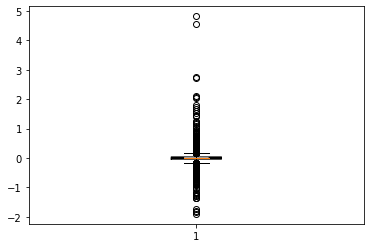

In [10]:
result = plt.boxplot(dcombine.alpha_real.values, bootstrap=1000, notch=True)

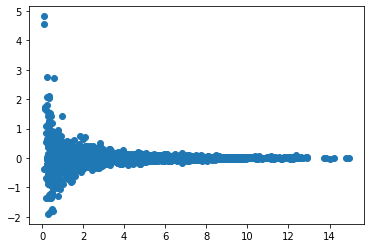

In [11]:
plt.scatter(np.sqrt(dcombine.vnorth_atmos**2 + dcombine.ueast_atmos**2), dcombine.alpha_real)

Interesting - large alphas for small winds- makes sense from the equation

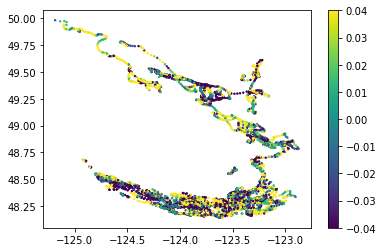

In [12]:
plt.scatter(dcombine.lon, dcombine.lat, c=dcombine.alpha_real,vmin=-0.04, vmax=0.04,s=2)
plt.colorbar()

# Drop really low wind speeds

In [13]:
dcombine_lowexclude = dcombine.where(np.sqrt(dcombine.ueast_atmos**2 + dcombine.vnorth_atmos**2) > 1)

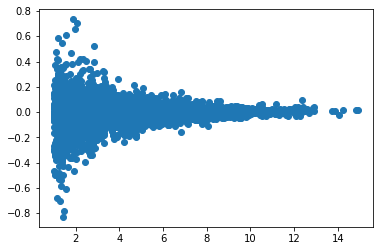

In [14]:
plt.scatter(np.sqrt(dcombine_lowexclude.vnorth_atmos**2 + dcombine_lowexclude.ueast_atmos**2), 
            dcombine_lowexclude.alpha_real)

In [15]:
print(np.nanmean(dcombine_lowexclude.alpha_real.values), np.nanmedian(dcombine_lowexclude.alpha_real.values))
print(np.nanmean(dcombine_lowexclude.alpha_imag.values), np.nanmedian(dcombine_lowexclude.alpha_imag.values))

-0.0005138120910243119 0.0006258689597381604
-0.0010014902249464047 0.0002629824040572951


In [16]:
print(np.nanstd(dcombine_lowexclude.alpha_real.values))
print(np.nanstd(dcombine_lowexclude.alpha_imag.values))

0.09418611227377453
0.09320777213077656


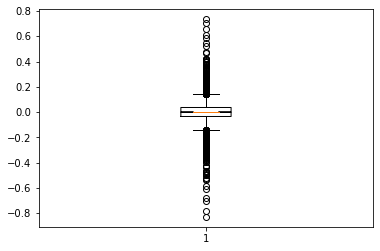

In [17]:
result = plt.boxplot(dcombine_lowexclude.dropna('i').alpha_real.values, bootstrap=1000, notch=True)